In [ ]:
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
    path_to_file = '/content/drive/MyDrive/Colab Notebooks/net_hydra/'
    print(path_to_file)
    # change current path to the folder containing "file_name"
    os.chdir(path_to_file)

/content/drive/MyDrive/Colab Notebooks/net_hydra/


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 68.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 99.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 26.7 MB/s eta 0:00:00


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [ ]:
import matplotlib.pyplot as plt
import re
from collections import OrderedDict
import torch
import transformers
from transformers import AlbertTokenizer, AlbertModel, DistilBertTokenizer, DistilBertModel, RobertaTokenizer, RobertaModel
from torch.utils.data import Dataset, DataLoader
from torch import cuda
from tqdm import tqdm
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
device = 'cuda' if cuda.is_available() else 'cpu'

In [ ]:
print(device)

cuda


### Task 3.5.3 ###


The Model MD12 was trained previously and saved under the name <b>"net_hydra.bin"</b> (Task 3.5.2 ). </br>  It is again reloaded for performing evaluation on <b>Validation Augmented Dataset</b>. 
</br>Final architecture to be used for Task 1 and Task 2 is pasted so that the reloaded trained model can access it.

In [ ]:
# Final architecture to be used for Task 1 and Task 2
class NetMultiTask(torch.nn.Module):
    def __init__(self):
        super(NetMultiTask, self).__init__()
        self.net = RobertaModel.from_pretrained("roberta-base")
        
        self.pre_classifier1 = torch.nn.Linear(768, 768)
        self.dropout1 = torch.nn.Dropout(0.2)
        self.classifier1 = torch.nn.Linear(768, 2)
        
        self.pre_classifier2 = torch.nn.Linear(768, 768)
        self.dropout2 = torch.nn.Dropout(0.2)
        self.classifier2 = torch.nn.Linear(768, 3)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.net(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
      
        pooler1 = self.pre_classifier1(pooler)
        pooler1 = torch.nn.ReLU()(pooler1)
        pooler1 = self.dropout1(pooler1)
        output1 = self.classifier1(pooler1)

        pooler2 = self.pre_classifier2(pooler)
        pooler2 = torch.nn.ReLU()(pooler2)
        pooler2 = self.dropout2(pooler2)
        output2 = self.classifier2(pooler2)
        
        return output1, output2

MD12 trained model name net_hydra.bin. 
</br> Link for the trained model is shared here 

https://drive.google.com/drive/folders/1KPzXWDcqeLanv2-buTIXSyiIDpH7_vQ2?usp=share_link 

Link will be open for about a month (16 th April to 31st May)

In [ ]:
model_path = "/content/drive/MyDrive/Colab Notebooks/net_hydra/net_hydra.bin" 
model_predict = torch.load(model_path, map_location=device)

In [ ]:
# Custom Dataset class for D_12
class DataCombined(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.text
        self.target = self.data.target
        self.sentiment = self.data.sentiment
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,
            padding = 'max_length',
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'labels': (self.target[index], self.sentiment[index]) #output labels in a tuple for indexing later during training loop
        }

Validation Augmented Dataset was saved in csv file after completion of Task 3.3 and is reloaded for Task 3.5.3 to evaluate MD12 on D1_val_hat for Task1 labels(Disaster) and Task2 labels(Sentiment). 

The augmented validation dataset has the original Target values of Disater tweets and in the next column Sentiment is the predicted output of MD2(text).

In [ ]:
dfvalaug=pd.read_csv("d1_val_augment.csv")

In [ ]:
dfvalaug.head()

Unnamed: 0                                               text  target  \
0           0  @BobbyofHomewood @JOXRoundtable as in dropping...       0   
1           1  Wreckage 'conclusively confirmed' as from miss...       1   
2           2  ??One night and we're gonna come and crash the...       0   
3           3  Greedy bastards @Fullscreen way to ruin creati...       0   
4           4  Dakota Skye gets horny with some porn then get...       0   

   sentiment  
0          0  
1          0  
2          1  
3          1  
4          0

In [ ]:
dfvalaug.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1523 entries, 0 to 1522
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  1523 non-null   int64 
 1   text        1523 non-null   object
 2   target      1523 non-null   int64 
 3   sentiment   1523 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 47.7+ KB


In [ ]:
dfvalaug_disaster = dfvalaug[['text','target']].copy()

In [ ]:
dfvalaug_sentiment = dfvalaug[['text','sentiment']].copy()

In [ ]:
dfvalaug_disaster.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1523 entries, 0 to 1522
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1523 non-null   object
 1   target  1523 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 23.9+ KB


In [ ]:
dfvalaug_sentiment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1523 entries, 0 to 1522
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       1523 non-null   object
 1   sentiment  1523 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 23.9+ KB


In [ ]:
# Now we know what to do, let's do the functions!

def null_tensor(tensor):
    if torch.isnan(tensor) == True:
        return torch.tensor(0)
    else:
        return tensor

def calcuate_accuracy(preds, targets):
    n_correct = (preds==targets).sum().item()
    return n_correct

In [ ]:
# Pre-trained tokenizer to be used
tokenizer = RobertaTokenizer.from_pretrained("roberta-base", do_lower_case=True)

In [ ]:
# # Hyperparameters below for actual model used
MAX_LEN = 512
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
LEARNING_RATE = 1e-05

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0
                }

In [ ]:
sd_val_aug_dataset = DataCombined(dfvalaug, tokenizer=tokenizer, max_len=MAX_LEN)
sd_val_aug_loader = DataLoader(sd_val_aug_dataset, **test_params)

**The below code is for getting the predicted values of validation data set for both task 1 labels and task 2 labels.** 
In MD12 predictions value with lambda 1 and 2 as 0.5

*  The output 1 gives results for Disaster classification

*  The output 2 gives results for Sentimet Classification




In [ ]:
def valid_hydra(model, testing_loader):
    model.eval()
    d1_predicts = []
    d2_predicts = []

    with torch.no_grad():
        for _, data in enumerate(tqdm(testing_loader, 0)):
            d1_ids = data['ids'][~np.isnan(data['labels'][0].numpy()) == True].to(device, dtype = torch.long)
            d1_mask = data['mask'][~np.isnan(data['labels'][0].numpy()) == True].to(device, dtype = torch.long)
            d1_token_type_ids = data['token_type_ids'][~np.isnan(data['labels'][0].numpy()) == True].to(device, dtype = torch.long)
            d1_targets = data['labels'][0][~np.isnan(data['labels'][0].numpy()) == True].long().to(device, dtype = torch.long)

            d2_ids = data['ids'][~np.isnan(data['labels'][1].numpy()) == True].to(device, dtype = torch.long)
            d2_mask = data['mask'][~np.isnan(data['labels'][1].numpy()) == True].to(device, dtype = torch.long)
            d2_token_type_ids = data['token_type_ids'][~np.isnan(data['labels'][1].numpy()) == True].to(device, dtype = torch.long)
            d2_sentiment = data['labels'][1][~np.isnan(data['labels'][1].numpy()) == True].long().to(device, dtype = torch.long)

            output1, _ = model(d1_ids, d1_mask, d1_token_type_ids)
            _, output2 = model(d2_ids, d2_mask, d2_token_type_ids)
            
            big_val_d1, big_idx_d1 = torch.max(output1.data, dim=1)
            big_val_d2, big_idx_d2 = torch.max(output2.data, dim=1)
            
            for i in range(d1_targets.size(0)):
                d1_predicts.append({
                    "predict": big_idx_d1[i].item(),
                    "target": d1_targets[i].item()
                })

            for i in range(d2_sentiment.size(0)):
                d2_predicts.append({
                    "predict": big_idx_d2[i].item(),
                    "sentiment": d2_sentiment[i].item()
                })

    d1_df = pd.DataFrame(d1_predicts)
    d2_df = pd.DataFrame(d2_predicts)

    return d1_df, d2_df

In [ ]:
d1_df, d2_df = valid_hydra(model_predict, sd_val_aug_loader)

100%|██████████| 48/48 [01:30<00:00,  1.88s/it]


In [ ]:
type(d1_df)

pandas.core.frame.DataFrame

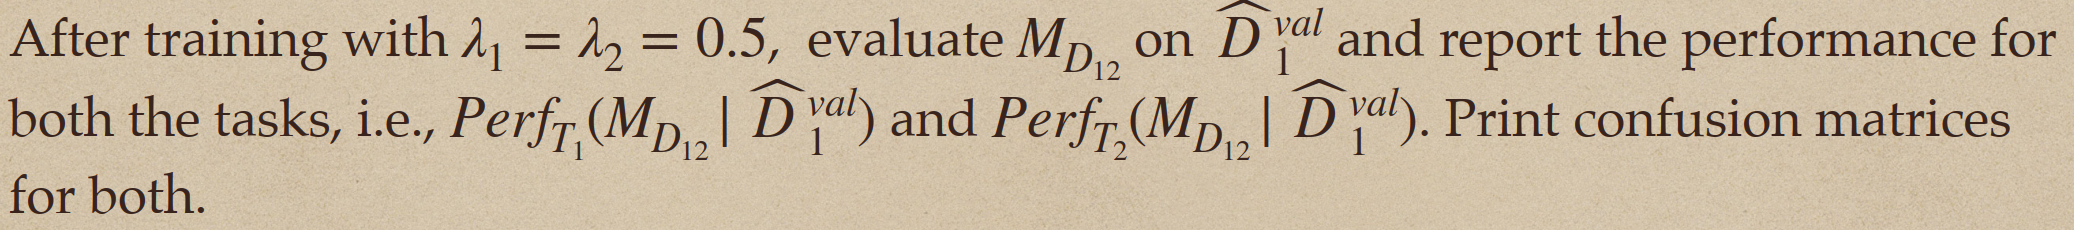

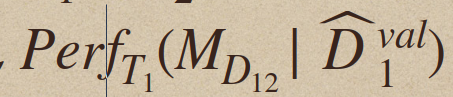

In [ ]:
print(classification_report(d1_df.target, d1_df.predict))
print(f"D1 F1: {f1_score(d1_df.target, d1_df.predict)}\n"
      f"D1 Accuracy: {accuracy_score(d1_df.target, d1_df.predict)}\n")

              precision    recall  f1-score   support

           0       0.85      0.89      0.87       869
           1       0.84      0.79      0.82       654

    accuracy                           0.85      1523
   macro avg       0.85      0.84      0.84      1523
weighted avg       0.85      0.85      0.85      1523

D1 F1: 0.8154574132492114
D1 Accuracy: 0.8463558765594222



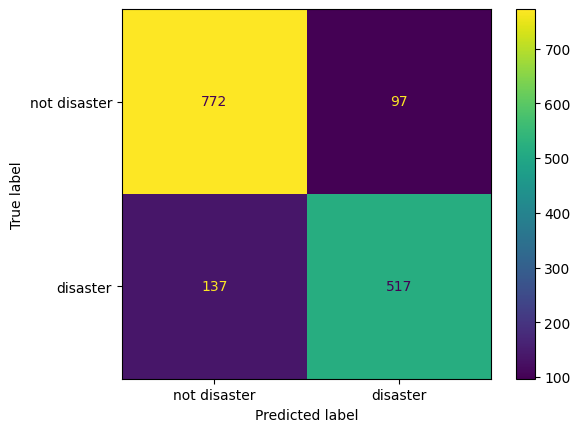

In [ ]:
cm_d1 = confusion_matrix(d1_df.target, d1_df.predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_d1, display_labels=['not disaster', 'disaster'])
disp.plot()
plt.show()

In [ ]:
# d1_df.to_csv("/content/drive/MyDrive/Colab Notebooks/net_hydra/d1_val_aug_pred_traila.csv")
# d2_df.to_csv("/content/drive/MyDrive/Colab Notebooks/net_hydra/d2_val_aug_pred_traila.csv")

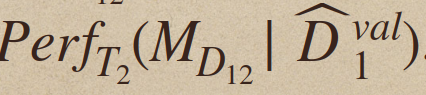

In [ ]:
print(classification_report(d2_df.sentiment, d2_df.predict))
print(f"D2 F1: {f1_score(d2_df.sentiment, d2_df.predict, average='weighted')}\n"
      f"D2 Accuracy: {accuracy_score(d2_df.sentiment, d2_df.predict)}\n")

              precision    recall  f1-score   support

           0       0.85      0.66      0.75       792
           1       0.67      0.91      0.77       580
           2       0.85      0.69      0.76       151

    accuracy                           0.76      1523
   macro avg       0.79      0.75      0.76      1523
weighted avg       0.78      0.76      0.76      1523

D2 F1: 0.7581425468818772
D2 Accuracy: 0.7596848325673013



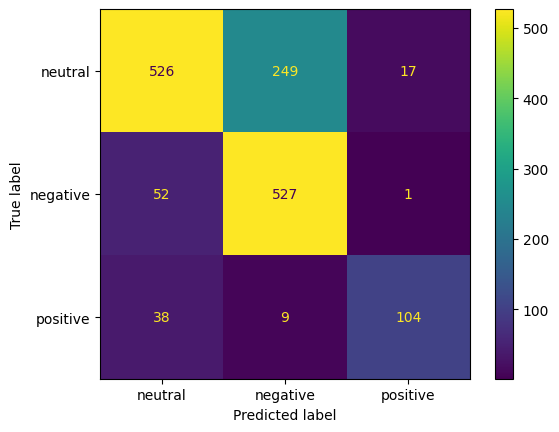

In [ ]:
cm_d2 = confusion_matrix(d2_df.sentiment, d2_df.predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_d2, display_labels=['neutral', 'negative','positive'])
disp.plot()
plt.show()

<b> Task 3.6 </b> </br>
<b>Lambda hyperparameter tuning using Ax</b>

In [ ]:
# pip install ax-platform

In [ ]:
from ax import optimize

In [ ]:
# Evaluation function for hyperparameter tuning
def valid_t1(model, testing_loader):
    d1_val_n_correct = 0
    d1_nb_val_examples = 0
    
    d1_predicts = []
    model.eval()
    with torch.no_grad():
        for _, data in enumerate(tqdm(testing_loader, 0)):
            d1_ids_val = data['ids'][~np.isnan(data['labels'][0].numpy()) == True].to(device, dtype = torch.long)
            d1_mask_val = data['mask'][~np.isnan(data['labels'][0].numpy()) == True].to(device, dtype = torch.long)
            #d1_token_type_ids_val = data['token_type_ids'][~np.isnan(data['labels'][0].numpy()) == True].to(device, dtype = torch.long)
            d1_targets_val = data['labels'][0][~np.isnan(data['labels'][0].numpy()) == True].long().to(device, dtype = torch.long)

            output1_val, _ = model(d1_ids_val, d1_mask_val)

            big_val_d1, big_idx_d1_val = torch.max(output1_val.data, dim=1)
            d1_val_n_correct += calcuate_accuracy(big_idx_d1_val, d1_targets_val)
            d1_nb_val_examples += d1_targets_val.size(0)

            for i in range(d1_targets_val.size(0)):
                d1_predicts.append({
                "predict": big_idx_d1_val[i].item(),
                "target": d1_targets_val[i].item()
            })
    d1_df = pd.DataFrame(d1_predicts)
    d1_f1 = f1_score(d1_df.target, d1_df.predict,  average='weighted')
    d1_accuracy = accuracy_score(d1_df.target, d1_df.predict)
    print(f"f1_Score: {d1_f1}")
    print(f"accuracy_Score: {d1_accuracy}")
    return d1_f1

Plase see `multitask_hydra_bo.py` for the working training script used

**Best Lambda Values**

 $\lambda_{1} =  0.6899408753961325$

$\lambda_{2}  = 0.4041465884074569$

$F1 = 0.846455693470444$


**Task 3.7**

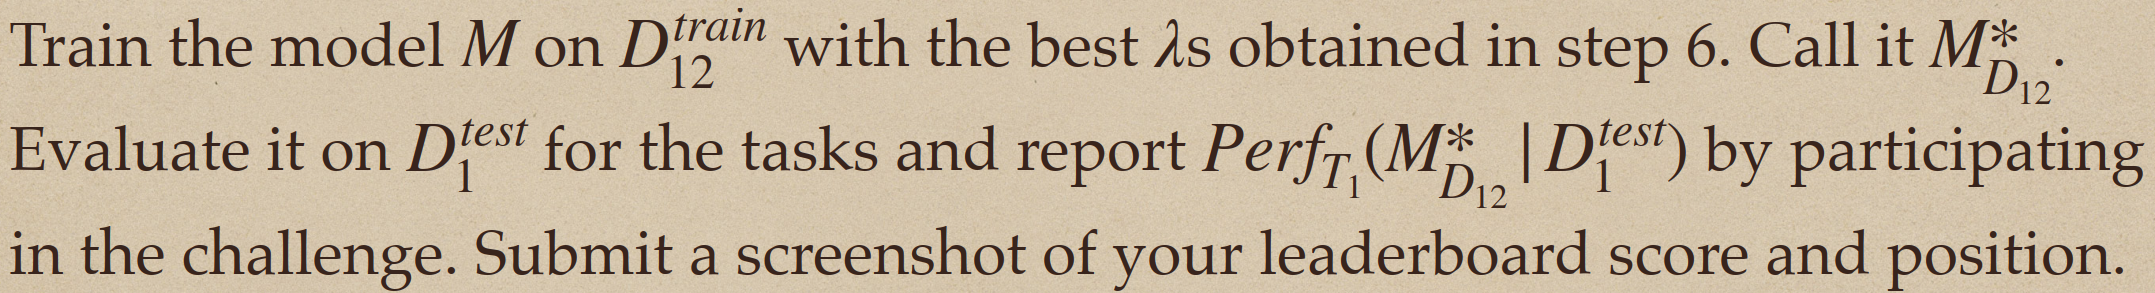

Please see multitask_hydra.py for the working training script used. Note that the optimum model was downloaded from the cluster and was renamed locally

In [ ]:
#Evaluate on D1 test Dataset
def predict_hydra_test_disaster(model, testing_loader):
  model.eval()
  d1_predicts = []

  with torch.no_grad():
      for _, data in enumerate(tqdm(testing_loader, 0)):
          d1_ids = data['ids'].to(device, dtype = torch.long)
          d1_mask = data['mask'].to(device, dtype = torch.long)
          d1_token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
          d1_index = data['index'].to(device,dtype = torch.long)
          output1,output2  = model(d1_ids, d1_mask, d1_token_type_ids)
          
          big_val_d1, big_idx_d1 = torch.max(output1.data, dim=1)
          
          for i in range(d1_ids.size(0)):
              d1_predicts.append({
                  "id": d1_index[i].item(),
                  "target": big_idx_d1[i].item(),
              })

  d1_df = pd.DataFrame(d1_predicts)

  return d1_df

Optimal Model saved after training Link is shared below. 

https://drive.google.com/drive/folders/1PUGXZa4oPl7do2cetTjXiIX4TUXyxbY-?usp=share_link

Link will be open for about a month (16 th April to 31st May)

In [ ]:
model_path_optim = "/content/drive/MyDrive/Colab Notebooks/net_hydra_optim/hydra_optim.bin" 
model_predict_optim = torch.load(model_path, map_location=device)

In [ ]:
d_test_orig = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/group_project/test.csv")

In [ ]:
print(f"d_test:{d_test_orig.shape}")

d_test:(3263, 4)


In [ ]:
d_test_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [ ]:
d_test = d_test_orig[['id','text']].copy()

In [ ]:
class TestData(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.text
        self.testindex = dataframe.id
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,
            padding = 'max_length',
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs['token_type_ids']

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            "token_type_ids": torch.tensor(token_type_ids, dtype=torch.long),
            "index": torch.tensor(self.testindex[index], dtype=torch.long)
        }

In [ ]:
d1_test_select =  d_test[['text','id']].copy()
d1_test_set = TestData(d1_test_select, tokenizer=tokenizer, max_len=MAX_LEN)
d1_test_loader= DataLoader(d1_test_set, **test_params)

In [ ]:
d1_test_hydra = predict_hydra_test_disaster(model_predict_optim, d1_test_loader)

100%|██████████| 102/102 [01:33<00:00,  1.09it/s]


In [ ]:
type(d1_test_hydra)

pandas.core.frame.DataFrame

In [ ]:
d1_test_hydra.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   id      3263 non-null   int64
 1   target  3263 non-null   int64
dtypes: int64(2)
memory usage: 51.1 KB


In [ ]:
d1_test_hydra.head(20)

id  target
0    0       1
1    2       1
2    3       1
3    9       1
4   11       1
5   12       1
6   21       0
7   22       0
8   27       0
9   29       0
10  30       0
11  35       0
12  42       0
13  43       0
14  45       0
15  46       1
16  47       0
17  51       0
18  58       0
19  60       0

In [ ]:
# d1_test_hydra.to_csv("/content/drive/MyDrive/Colab Notebooks/net_hydra_optim/d1_test_multiNueral_optim.csv",index=False)

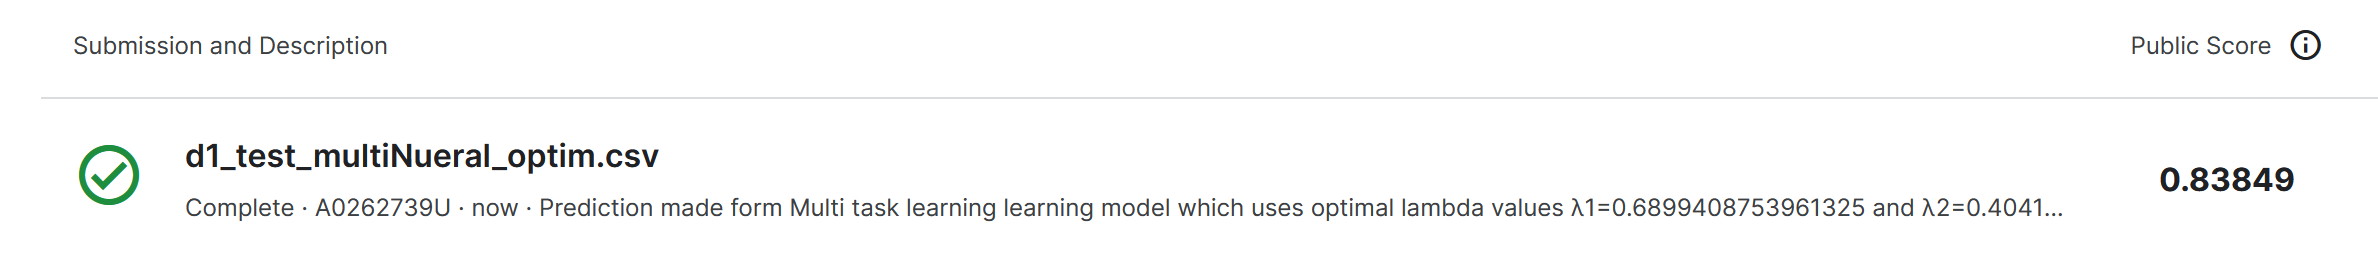

**Task 3.8**

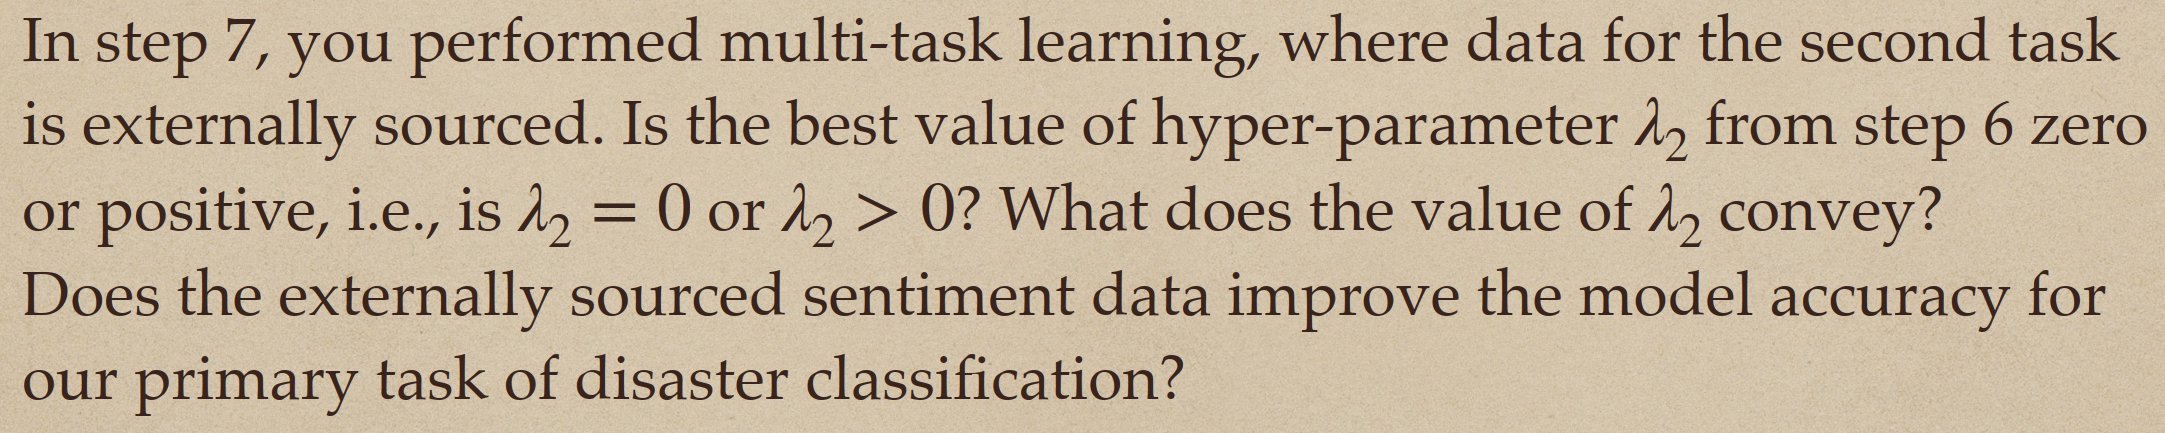

The best value of hyper-parameter lambda_{2} > 0 . 
<br>Since lambda_2 is less than lambda_1, higher emphasis is given on task 1 while training the model.
<br>The externally sourced sentiment data improve the model accuracy for our primary task of disaster classification.

**Task 3.9**

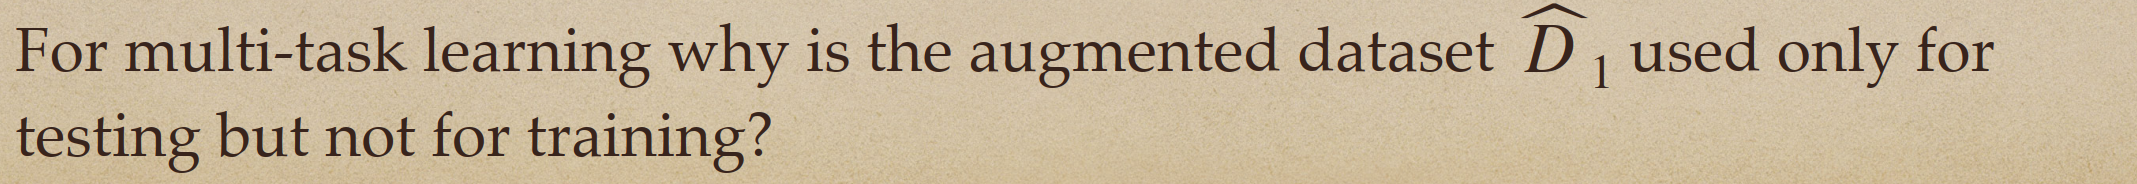

The augmented dataset has original disaster target labels and the sentiment labels are the predicted values from MD2(Trained with Sentiment Data) by passing the disaster texts to it. 

If the augmented dataset is used for model training then the model is more likely to overfit to these samples and cannot better generalize to new data.

When the label of a D12 sample is Null, the corresponding loss is considered as 0 during multi-task network training. This means that the loss associated with that task is effectively ignored and does not contribute to the overall loss function. As a result, the model is not penalized for making incorrect predictions on samples with null labels.